In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7JUXXH/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7JUXXH/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7JUXXH/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [4]:
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = ""

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [6]:
import tensorflow as tf

embedding_dim = 16
gru_dim = 32
dense_dim = 6

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [8]:
history_gru = model_gru.fit(padded, training_labels_final, batch_size=128, epochs=10, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 37s 164ms/step - loss: 0.6296 - accuracy: 0.6144 - val_loss: 0.4167 - val_accuracy: 0.8245
Epoch 2/10
196/196 [==============================] - 33s 168ms/step - loss: 0.3490 - accuracy: 0.8523 - val_loss: 0.3515 - val_accuracy: 0.8459
Epoch 3/10
196/196 [==============================] - 48s 244ms/step - loss: 0.2654 - accuracy: 0.8975 - val_loss: 0.3689 - val_accuracy: 0.8397
Epoch 4/10
196/196 [==============================] - 31s 159ms/step - loss: 0.2193 - accuracy: 0.9198 - val_loss: 0.3984 - val_accuracy: 0.8378
Epoch 5/10
196/196 [==============================] - 31s 157ms/step - loss: 0.1889 - accuracy: 0.9346 - val_loss: 0.4781 - val_accuracy: 0.8294
Epoch 6/10
196/196 [==============================] - 32s 161ms/step - loss: 0.1655 - accuracy: 0.9427 - val_loss: 0.4706 - val_accuracy: 0.8251
Epoch 7/10
196/196 [==============================] - 31s 161ms/step - loss: 0.1424 - accuracy: 0.9524 - val_loss: 0.5138 - val_ac

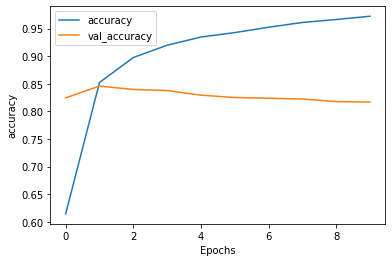

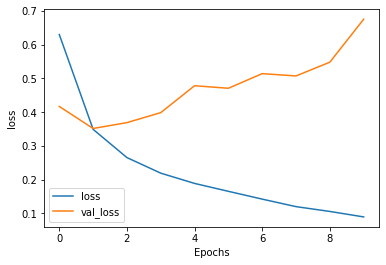

In [9]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history_gru, "accuracy")
plot_graphs(history_gru, "loss")

The validation loss is quite high than training loss using just GRU